# 高阶API示范

Pytorch没有官方的高阶API，一般需要用户自己实现训练循环、验证循环、和预测循环。

In [1]:
import datetime
from torchkeras import Model, summary

#打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

## 线性回归模型

In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt

In [3]:
# 样本数量
n = 400
# 生成测试用数据集
X = 10 * torch.rand([n, 2],) - 5.0
w0 = torch.tensor([[2.0], [-3.0]])
b0 = torch.tensor([[10.0]])
Y = X@w0 + b0 + torch.normal(0.0, 2.0, size=[n, 1])

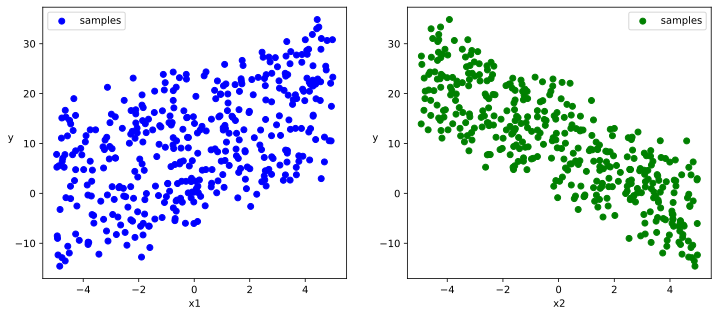

In [4]:
# 数据可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize=(12, 5))

ax1 = plt.subplot(121)
ax1.scatter(X[:, 0].numpy(), Y[:, 0].numpy(), c='b', label='samples')
ax1.legend()
plt.xlabel('x1')
plt.ylabel('y', rotation=0)

ax2 = plt.subplot(122)
ax2.scatter(X[:, 1].numpy(), Y[:, 0].numpy(), c='g', label='samples')
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y", rotation=0)

plt.show()

In [5]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

ds = TensorDataset(X, Y)
ds_train, ds_valid = torch.utils.data.random_split(ds, [int(400 * 0.7), 400 - int(400 * 0.7)])
dl_train = DataLoader(ds_train, batch_size=10, shuffle=True)
dl_valid = DataLoader(ds_valid, batch_size=10)

In [6]:
from torchkeras import Model

class LinearRegression(Model):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.fc = nn.Linear(2, 1)

    def forward(self,x):
        return self.fc(x)

model = LinearRegression()

In [7]:
model.summary(input_shape=(2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 1]               3
Total params: 3
Trainable params: 3
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000008
Forward/backward pass size (MB): 0.000008
Params size (MB): 0.000011
Estimated Total Size (MB): 0.000027
----------------------------------------------------------------


In [8]:
def mean_absolute_error(y_pred, y_true):
    return torch.mean(torch.abs(y_true - y_pred))

def mean_absolute_percent_error(y_pred, y_true):
    absolute_percent_error = (torch.abs(y_pred - y_true) + 1e-7) / (torch.abs(y_true) + 1e-7)
    return torch.mean(absolute_percent_error)

model.compile(loss_func=nn.MSELoss(), optimizer=torch.optim.Adam(model.parameters(), lr=0.01),
              metrics_dict={"mae" : mean_absolute_error, "mape" : mean_absolute_percent_error})

df_history = model.fit(epochs=200, dl_train=dl_train, dl_val=dl_valid, log_step_freq=20)

Start Training ...

================================================================================2021-02-06 17:40:11
{'step': 20, 'loss': 183.053, 'mae': 11.344, 'mape': 1.44}

 +-------+---------+-------+-------+----------+---------+----------+
| epoch |   loss  |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+---------+-------+-------+----------+---------+----------+
|   1   | 186.771 | 11.53 | 1.468 | 169.374  |  10.604 |  1.185   |
+-------+---------+-------+-------+----------+---------+----------+

================================================================================2021-02-06 17:40:11
{'step': 20, 'loss': 161.292, 'mae': 10.816, 'mape': 1.529}

 +-------+---------+--------+-------+----------+---------+----------+
| epoch |   loss  |  mae   |  mape | val_loss | val_mae | val_mape |
+-------+---------+--------+-------+----------+---------+----------+
|   2   | 166.627 | 10.954 | 1.586 |  152.08  |  10.153 |  1.255   |
+-------+---------+--------+-------+----

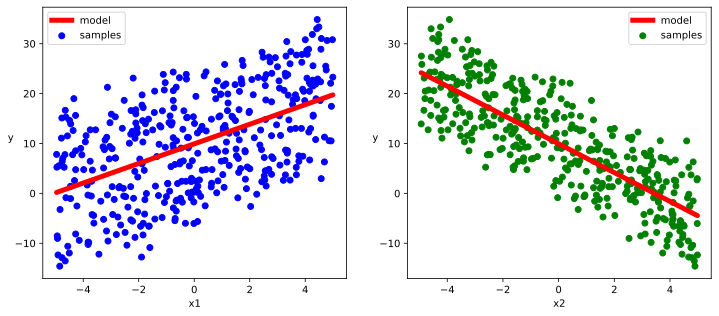

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

w, b = model.state_dict()["fc.weight"], model.state_dict()["fc.bias"]

plt.figure(figsize=(12, 5))
ax1 = plt.subplot(121)
ax1.scatter(X[:, 0], Y[:, 0], c="b", label="samples")
ax1.plot(X[:, 0], w[0, 0] * X[:, 0] + b[0], "-r", linewidth=5.0, label="model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y", rotation=0)

ax2 = plt.subplot(122)
ax2.scatter(X[:, 1], Y[:, 0], c="g", label="samples")
ax2.plot(X[:, 1], w[0, 1] * X[:, 1] + b[0], "-r", linewidth=5.0, label="model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y", rotation = 0)

plt.show()

In [10]:
df_history.tail()

,loss,mae,mape,val_loss,val_mae,val_mape
195,3.409292,1.487741,0.442324,4.465856,1.724536,0.419232
196,3.415792,1.491446,0.442503,4.429016,1.717683,0.418477
197,3.410723,1.488436,0.442326,4.457571,1.717612,0.416924
198,3.414347,1.489176,0.439807,4.433698,1.716008,0.417533
199,3.421668,1.488108,0.441039,4.515185,1.734463,0.419983


In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

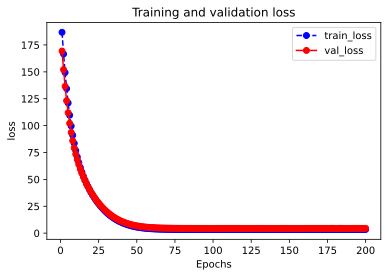

In [12]:
plot_metric(df_history, "loss")

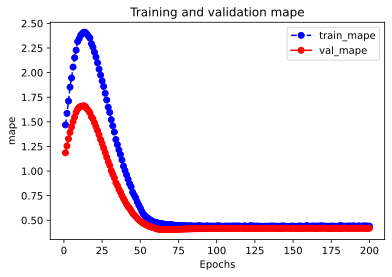

In [13]:
plot_metric(df_history, "mape")

In [14]:
model.evaluate(dl_valid)

{'val_loss': 4.5151852170626325,
 'val_mae': 1.734462598959605,
 'val_mape': 0.4199830448875825}

In [15]:
dl = DataLoader(TensorDataset(X))
model.predict(dl)[0:10]


tensor([[ 8.4808],
        [21.7796],
        [22.5702],
        [-0.4077],
        [23.8163],
        [ 1.6375],
        [15.0652],
        [15.5007],
        [13.0825],
        [ 1.6809]])

## DNN二分类模型

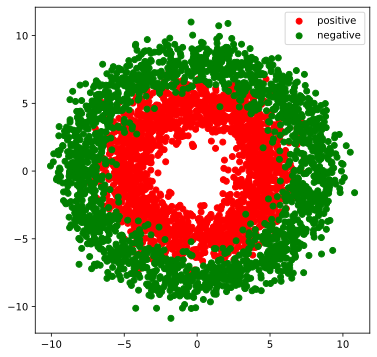

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

#正负样本数量
n_positive, n_negative = 2000, 2000

r_p = 5.0 + torch.normal(0.0, 1.0, size=[n_positive, 1])
theta_p = 2 * np.pi * torch.rand([n_positive, 1])
Xp = torch.cat([r_p * torch.cos(theta_p), r_p * torch.sin(theta_p)], axis=1)
Yp = torch.ones_like(r_p)

r_n = 8.0 + torch.normal(0.0, 1.0, size=[n_negative, 1])
theta_n = 2 * np.pi * torch.rand([n_negative, 1])
Xn = torch.cat([r_n * torch.cos(theta_n), r_n * torch.sin(theta_n)], axis=1)
Yn = torch.zeros_like(r_n)

X = torch.cat([Xp, Xn], axis=0)
Y = torch.cat([Yp, Yn], axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(Xp[:, 0].numpy(), Xp[:, 1].numpy(), c='r')
plt.scatter(Xn[:, 0].numpy(), Xn[:, 1].numpy(), c='g')
plt.legend(['positive', 'negative'])

In [17]:
#构建输入数据管道

from torch.utils.data import Dataset, DataLoader, TensorDataset

ds = TensorDataset(X, Y)
ds_train, ds_valid = torch.utils.data.random_split(ds, [int(len(ds) * 0.7), len(ds) - int(len(ds) * 0.7)])
dl_train = DataLoader(ds_train, batch_size=100, shuffle=True)
dl_valid = DataLoader(ds_valid, batch_size=100)

In [19]:
import torch.nn.functional as F
import torchkeras

class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 8)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        y = nn.Sigmoid()(self.fc3(x))

        return y

model = torchkeras.Model(DNNModel())
model.summary(input_shape=(2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 4]              12
            Linear-2                    [-1, 8]              40
            Linear-3                    [-1, 1]               9
Total params: 61
Trainable params: 61
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000008
Forward/backward pass size (MB): 0.000099
Params size (MB): 0.000233
Estimated Total Size (MB): 0.000340
----------------------------------------------------------------


In [20]:
def accuracy(y_pred, y_true):
    y_pred = torch.where(y_pred > 0.5, torch.ones_like(y_pred, dtype=torch.float32), torch.zeros_like(y_pred, dtype=torch.float32))
    acc = torch.mean(1 - torch.abs(y_pred - y_true))
    return acc

model.compile(loss_func=nn.BCELoss(), optimizer=torch.optim.Adam(model.parameters(), lr=0.01),
              metrics_dict={'accuracy' : accuracy})

df_history = model.fit(epochs=100, dl_train=dl_train, dl_val=dl_valid, log_step_freq=10)

Start Training ...

================================================================================2021-02-06 17:48:50
{'step': 10, 'loss': 0.703, 'accuracy': 0.542}
{'step': 20, 'loss': 0.676, 'accuracy': 0.551}

 +-------+------+----------+----------+--------------+
| epoch | loss | accuracy | val_loss | val_accuracy |
+-------+------+----------+----------+--------------+
|   1   | 0.66 |   0.58   |  0.615   |    0.693     |
+-------+------+----------+----------+--------------+

================================================================================2021-02-06 17:48:50
{'step': 10, 'loss': 0.612, 'accuracy': 0.707}
{'step': 20, 'loss': 0.595, 'accuracy': 0.739}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   2   | 0.577 |  0.746   |  0.532   |     0.72     |
+-------+-------+----------+----------+--------------+

=========================================

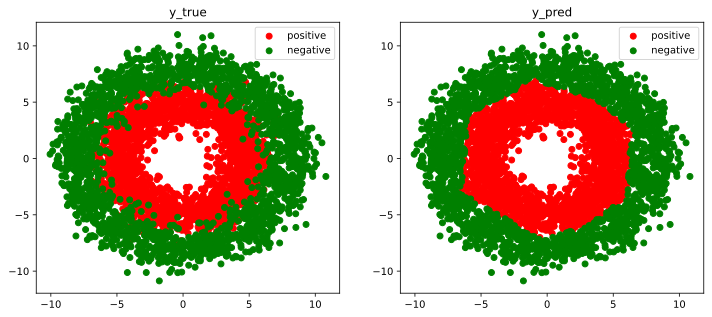

In [21]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize = (12,5))
ax1.scatter(Xp[:,0], Xp[:,1], c="r")
ax1.scatter(Xn[:,0], Xn[:,1], c = "g")
ax1.legend(["positive", "negative"]);
ax1.set_title("y_true");

Xp_pred = X[torch.squeeze(model.forward(X) >= 0.5)]
Xn_pred = X[torch.squeeze(model.forward(X) < 0.5)]

ax2.scatter(Xp_pred[:, 0], Xp_pred[:, 1], c = "r")
ax2.scatter(Xn_pred[:, 0], Xn_pred[:, 1], c = "g")
ax2.legend(["positive", "negative"]);
ax2.set_title("y_pred");

In [22]:
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

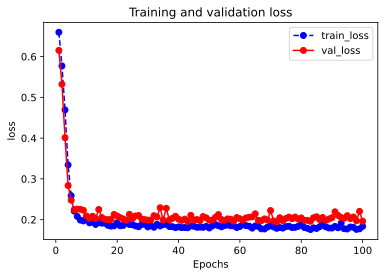

In [23]:
plot_metric(df_history, "loss")

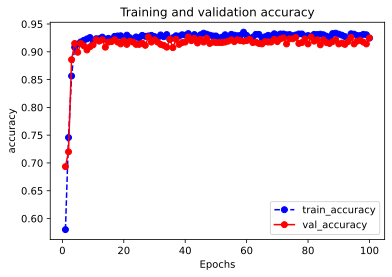

In [24]:
plot_metric(df_history, "accuracy")

In [25]:
model.evaluate(dl_valid)

{'val_loss': 0.19627443701028824, 'val_accuracy': 0.9250000069538752}

In [26]:
model.predict(dl_valid)[0:10]

tensor([[0.9983],
        [0.0016],
        [0.9980],
        [0.5936],
        [0.8822],
        [0.9925],
        [0.9136],
        [0.9993],
        [0.0139],
        [0.4398]])